In [1]:
import os
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import kaldiio

from scipy.signal import welch
import random
from sklearn.manifold import TSNE
import plotly.graph_objects as go

import plotly.io as pio

pio.renderers.default = "notebook"

from IPython.display import Audio

import tensorflow as tf
import tensorflow_io as tfio

load_dotenv("../.env")
tf.config.list_physical_devices("GPU")

# conda install -c conda-forge tqdm

2023-04-26 23:05:18.504928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 23:05:19.186584: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-26 23:05:19.883922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 23:05:20.039309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 23:05:20.039371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
PROJECT_ROOT = os.getenv("PROJECT_ROOT")
os.chdir(PROJECT_ROOT)

CLIPS_PATH = os.getenv("CLIPS_PATH")

VALIDATED_LIST_PATH = os.path.join(os.getenv("CLIPS_META_PATH"), "validated.tsv")
XVECTOR_RESULT_PATH = os.getenv("XVECTOR_RESULT_PATH")
XVECTOR_SCP_PATH = os.path.join(XVECTOR_RESULT_PATH, "xvector.scp")


In [3]:
speakers_xvectors = kaldiio.load_scp(XVECTOR_SCP_PATH)
valid_speakers = set(speakers_xvectors.keys())

raw_clips_meta = pd.read_table(VALIDATED_LIST_PATH)
raw_clips_meta = raw_clips_meta[raw_clips_meta["client_id"].isin(valid_speakers)]


def get_path(row):
    return f"{CLIPS_PATH}/{row}.mp3"


In [4]:
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    Concatenate,
    LeakyReLU,
    BatchNormalization,
    Flatten,
    AveragePooling2D,
    Dense,
    Dropout,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Model


In [5]:
HYPER_PARAMS = {
    # Model parameters
    "window-width": 64,
    "mel-bands": 256,
    "x-vector-dim": 512,
    # Training parameters
    "batch-size": 32,
    "epochs": 100,
    "learning-rate": 0.0001,
    "learn-test-split": 0.8,
    # FFT parameters
    "nfft": 8192,
    "fft-window": 4096,
    "fft-stide": 512,
}

# Model parameters
mel_spectrogram_shape = (
    HYPER_PARAMS["window-width"],
    HYPER_PARAMS["mel-bands"],
    1,
)  # Replace window_size and num_mel_bands with your values

# Leaky ReLU activation function
leaky_relu = LeakyReLU(alpha=0.2)

# Mel-spectrogram input
mel_spectrogram_input = Input(shape=mel_spectrogram_shape, name="mel_spectrogram_input")

# Convolutional layers
x = Conv2D(16, (3, 3), padding="same", activation=leaky_relu)(mel_spectrogram_input)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Convolutional layers
x = Conv2D(32, (3, 3), padding="same", activation=leaky_relu)(mel_spectrogram_input)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), padding="same", activation=leaky_relu)(x)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), padding="same", activation=leaky_relu)(x)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)

# X-vector input
x_vector_input = Input(shape=(HYPER_PARAMS["x-vector-dim"],), name="x_vector_input")

# Concatenate flattened CNN output with x-vector input
combined_input = Concatenate()([x, x_vector_input])

# Dense layers
y = Dense(128, activation=leaky_relu)(combined_input)
y = Dropout(0.1)(y)
y = Dense(256, activation=leaky_relu)(y)
y = Dropout(0.1)(y)
y = Dense(256, activation=leaky_relu)(y)
y = Dropout(0.1)(y)
y = Dense(512, activation=leaky_relu)(y)
output = Dense(HYPER_PARAMS["mel-bands"], activation="linear")(y)

# Construct the model
model = Model(inputs=[mel_spectrogram_input, x_vector_input], outputs=output)
model.summary()

# Compile the model
optimizer = Adam(learning_rate=HYPER_PARAMS["learning-rate"])
loss_fn = MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss_fn)


2023-04-26 23:05:30.033694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 23:05:30.033795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 23:05:30.033840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 23:05:30.958308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 23:05:30.958391: I tensorflow/compile

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mel_spectrogram_input (InputLa  [(None, 64, 256, 1)  0          []                               
 yer)                           ]                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 256, 32)  320         ['mel_spectrogram_input[0][0]']  
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 64, 256, 32)  128        ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                              

In [6]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(histogram_freq=1)

In [20]:
class SamplesLoader:
    def __init__(self, audio_samples, x_vectors, samples_coeficients, params):
        self.audio_samples = audio_samples
        self.x_vectors = x_vectors

        self.batch_size = params["batch-size"]
        self.split = params["learn-test-split"]
        self.nfft = params["nfft"]
        self.fft_window = params["fft-window"]
        self.fft_stride = params["fft-stride"]

        self.samples_coeficients = samples_coeficients

        sampled_samples = self.audio_samples.sample(frac=1)
        samlpes_length = sampled_samples.shape[0]
        split_index = int(samlpes_length * self.split)

        self.train_iterator = sampled_samples.iloc[:split_index].iterrows()
        self.test_iterator = sampled_samples.iloc[split_index:].iterrows()

        self.current_file = None
        self.train_batch = {
            "input": tf.zeros(shape=(0, 20, 1280)),
            "x-vector": tf.zeros(shape=(0, 512)),
            "output": tf.zeros(shape=(0, 20, 1280)),
        }
        self.test_batch = []

    def _get_batch(self, iterator):
        pass

    # Return a batch or None if there are no more batches
    def get_train_batch(self):
        # If we have enough samples to make a whole batch, return it
        if len(self.train_batch) > self.batch_size:
            batch = self.train_batch[: self.batch_size]
            self.train_batch = self.train_batch[self.batch_size :]
            return batch

        while self.train_batch["input"].shape[0] < self.batch_size:
            iter_result = self.train_iterator.__next__()
            if iter_result is None:
                if self.train_batch["input"].shape[0] == 0:
                    return None
                
                # TODO: Pad with zeros

            sample_index, new_sample = iter_result
            audio = tfio.audio.AudioIOTensor(get_path(new_sample["path"]))
            if audio.shape[0] < 1000: # Skip to short samples
                continue

            audio_tensor = tf.squeeze(audio[300:-350], axis=[-1])
            # TODO: Apply required transformations (noise, raw, conversation, etc.)

            
            spectrogram = tfio.audio.spectrogram(
                audio_tensor,
                nfft=self.nfft,
                window=self.fft_window,
                stride=self.fft_stride,
            )

            # Slice away frequencies outside of the human voice range
            sliced_tensor = tf.slice(spectrogram, [0, 0], [spectrogram.shape[0], 1280])
            mean = tf.math.reduce_mean(sliced_tensor)
            std_dev = tf.math.reduce_std(sliced_tensor)
            final_tensor = (spectrogram - mean) / std_dev

            window_size_x = 20
            window_size_y = 1280
            stride_x = 1
            stride_y = 1280

            # Calculate required padding for the first axis
            padding_x = (window_size_x - 1) // 2
            padding_y = 0

            # Apply padding to the tensor
            padded_tensor = tf.pad(final_tensor, paddings=[[padding_x, padding_x], [padding_y, padding_y]])
            padded_tensor_expanded = tf.expand_dims(tf.expand_dims(padded_tensor, axis=0), axis=-1)

            patches = tf.image.extract_patches(
                images=padded_tensor_expanded,
                sizes=[1, window_size_x, window_size_y, 1],
                strides=[1, stride_x, stride_y, 1],
                rates=[1, 1, 1, 1],
                padding='VALID'
            )


            # Reshape patches to the desired format
            num_patches_x = (padded_tensor.shape[0] - window_size_x) // stride_x + 1
            num_patches_y = (padded_tensor.shape[1] - window_size_y) // stride_y + 1
            patches = tf.reshape(patches, (num_patches_x, num_patches_y, window_size_x, window_size_y))

            # Remove the singleton dimensions
            sample_patches = tf.squeeze(patches, axis=[1])
            self.train_batch["input"] = tf.concat([self.train_batch["input"], sample_patches], axis=0)


            


        return self.get_batch(self.train_iterator)

    # Return a batch or None if there are no more batches
    def get_test_batch(self):
        return self.get_batch(self.test_iterator)

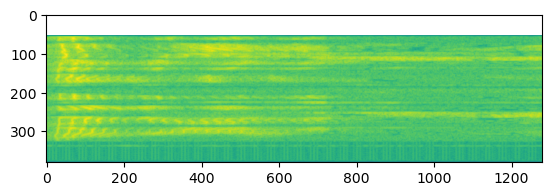

In [14]:
iter = raw_clips_meta.sample(1).iterrows()
index, row = iter.__next__()

audio = tfio.audio.AudioIOTensor(get_path(row["path"]))
audio_tensor = tf.squeeze(audio[300:-350], axis=[-1])
spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=8192, window=4096, stride=512)

sliced_tensor = tf.slice(spectrogram, [0, 0], [spectrogram.shape[0], 1280])
zeros_tensor = tf.zeros([spectrogram.shape[0], 2817], dtype=sliced_tensor.dtype)
concatenated_tensor = tf.concat([sliced_tensor, zeros_tensor], axis=1)

plt.figure()
plt.imshow(tf.math.log(sliced_tensor).numpy())


In [19]:
tf.random.normal(shape=(1, 380, 1280, 1), mean=0, stddev=1)


<tf.Tensor: shape=(1, 380, 1280, 1), dtype=float32, numpy=
array([[[[ 1.0799572 ],
         [-0.03621118],
         [-0.80383176],
         ...,
         [-2.3145895 ],
         [-0.66456884],
         [ 0.9894518 ]],

        [[-0.1192361 ],
         [ 0.72834903],
         [ 0.2752486 ],
         ...,
         [ 0.5507933 ],
         [ 0.52134264],
         [-1.1598959 ]],

        [[-0.63035166],
         [ 0.44987115],
         [ 0.12278361],
         ...,
         [-0.7386746 ],
         [ 0.06410153],
         [ 0.45298284]],

        ...,

        [[ 0.05914515],
         [ 0.5479356 ],
         [-0.48165628],
         ...,
         [-0.27343613],
         [ 1.9891757 ],
         [ 1.2399687 ]],

        [[ 0.59366167],
         [-0.08148408],
         [-0.9541997 ],
         ...,
         [-1.8306993 ],
         [-0.67550886],
         [ 0.03519792]],

        [[ 0.3102408 ],
         [ 0.29012835],
         [ 1.2727284 ],
         ...,
         [-1.4944612 ],
         [-0.1785

In [15]:
spectrogram
a = tf.math.log(sliced_tensor).numpy()

# Assuming your array is named `my_array`
hist_values, bin_edges = np.histogram(a)

# Plot the histogram
plt.hist(a, bins=bin_edges)
plt.show()

ValueError: autodetected range of [-inf, 2.7213022708892822] is not finite

In [17]:
np.mean(sliced_tensor)

0.045435376

In [209]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())


In [190]:
inverse_audio = tfio.audio.inverse_spectrogram(
    concatenated_tensor, nfft=8192, window=4096, stride=512, iterations=60
)

Audio(inverse_audio.numpy(), rate=audio.rate.numpy())


In [52]:
audio_tensor


<tf.Tensor: shape=(147456,), dtype=float32, numpy=
array([ 0.0000000e+00,  5.4708640e-17,  1.4651049e-17, ...,
       -5.1793168e-06, -1.6393100e-06, -1.9682780e-06], dtype=float32)>

In [30]:
SAMPLE_COEFICIENTS = {
    "raw": 0.8,
    "empty": 0.1,
    "noisy": 0.4,
    "combined": 0.1,
    "noisy_combined": 0.1,
}

data_loader = SamplesLoader(
    raw_clips_meta, speakers_xvectors, SAMPLE_COEFICIENTS, HYPER_PARAMS
)

In [31]:
b = iter(data_loader)


In [25]:
b.__next__()


Loading sample 44257 from /home/user/commonvoice/en_Common_Voice_Corpus_1/clips/ecdbfbe498fcbef336569e4902bcc6c7c03d9e72a53b427801948f7baa9d64b89bf64e3ff6dc71a8fd5351a5747455b1bb3fdca94c51b79fd5a150c8b62e169e.mp3


<AudioIOTensor: shape=[254592      1], dtype=<dtype: 'float32'>, rate=48000>

In [14]:
# Training parameters
epochs = 50
train_steps_per_epoch = 2000  # Adjust this value based on your training set size
val_steps_per_epoch = 500  # Adjust this value based on your validation set size

for epoch in tqdm(range(HYPER_PARAMS["epochs"]), desc="Training"):
    pass
    # Train on batches
    # for batch_X_mel, batch_X_xvec, batch_y in train_dataset:
    #     train_result = model.train_on_batch(
    #         x=[batch_X_mel, batch_X_xvec], y=batch_y, reset_metrics=False
    #     )

    #     # Write train metrics to TensorBoard
    #     with tensorboard_callback.as_default():
    #         tf.summary.scalar("loss", train_result, step=epoch)

    # Validate on batches
    # val_losses = []
    # for batch_X_mel, batch_X_xvec, batch_y in val_dataset:
    #     val_result = model.test_on_batch(x=[batch_X_mel, batch_X_xvec], y=batch_y)

    #     # Collect validation losses
    #     val_losses.append(val_result)

    # Write validation metrics to TensorBoard
    # mean_val_loss = np.mean(val_losses)
    # with tensorboard_callback.as_default():
    #     tf.summary.scalar("val_loss", mean_val_loss, step=epoch)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html